In [8]:
#@title Copyright 2020 Google LLC. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Linear Regression with a Real Dataset

notebook ini menggunakan dataset real untuk memprediksi harga rumah di California

## Learning Objectives:

Setelah menyelesaikan notebook ini, Kamu akan tau tentang :
- Membaca sebuah file .csv ke dalam pandas DataFrame
- Memeriksa dataset
- Bereksperimen dengan fitur berbeda dalam pembuatan model
- Tuning hyperparameter model

## The Dataset
  
[dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) yang digunakan merupakan data sensus di California pada tahun 1990. Merupakan dataset lama tapi masih bagus dipake untuk machine learning program.

## Import modul yang dibutuhkan

In [9]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

## Dataset

Dataset biasanya tersimpan di disk komputer yang akan digunakan atau diakses lewat URL dalam bentuk csv (Comma Separated Value). 

file .csv yang baik biasanya berisi nama kolom di baris pertama, diikuti dengan data di baris-baris selanjutnya. Koma memisahkan setiap nilai di setiap barisnya. Sebagai contoh, ini merupakan 5 baris pertama dari dataset rumah California.

```
"longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"
-114.310000,34.190000,15.000000,5612.000000,1283.000000,1015.000000,472.000000,1.493600,66900.000000
-114.470000,34.400000,19.000000,7650.000000,1901.000000,1129.000000,463.000000,1.820000,80100.000000
-114.560000,33.690000,17.000000,720.000000,174.000000,333.000000,117.000000,1.650900,85700.000000
-114.570000,33.640000,14.000000,1501.000000,337.000000,515.000000,226.000000,3.191700,73400.000000
```

## Load csv file ke dalam pandas DataFrame

Kode dibawah akan mengimport csv file ke dalam pandas DataFrame dan menskalakan nilai label (`median_house_value`):

In [10]:
# import the dataset
training_df = pd.read_csv(filepath_or_buffer="https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")

training_df["median_house_value"] /= 1000.0

# Print baris-baris awal di dataframe
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5


Menskalakan `median_house_value` membuat nilai dari setiap rumah dalam unit ribuan (bukan puluhan ribu atau ratusan ribu). Penskalaan akan menjaga loss values dan learning rate dalam range yang lebih bersahabat.

Walaupun penskalaan label biasanya tidak penting, penskalaan feature dalam model multi-feature biasanya penting.

## Mengecek dataset

Bagian besar dari projek machine learning adalah memahami data. Pandas API menyediakan fungsi `describe` yang akan mengeluarkan statistik dari setiap kolom di DataFrame:
- `count`, yang mana merupakan jumlah baris di kolom tersebut. Idealnya, `count` berisi nilai yang sama di setiap kolom.
- `mean` dan `std`, yang berisi nilai mean (rata-rata) dan standar deviasi di setiap kolomnya
- `min` dan `max`, yang berisi nilai terkecil dan nilai terbesar di setiap kolom.
- `25%`, `50%`, dan `75%` , berisi nilai kuantil

In [11]:
# Get statistic on the dataset
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


# Task 1: Identify anomalies in the dataset


Do you see any anomalies (strange values) in the data? 

## Jawaban dari Google

nilai maksimum (max) beberapa kolom terlihat sangat tinggi jika dibandingkan dengan kuantil lainnya. Sebagai contoh `total_rooms`. Kamu bisa berekspektasi nilai maksimum dari `total_rooms` adalah 5000 atau mendekati 10.000. Tapi data yang sebenarnya adalah 37.937.

Ketika kamu melihat sebuah anomali di dalam kolom, lebih berhati-hatilah menggunakan kolom tersebut sebagai sebuah feature. Bisa saja, anomali di potential feature merupakan cerminan dari anomali di dalam label, yang mana membuat kolom tersebut tampaknya feature yang powerful.

## Mendefinisikan fungsi untuk build dan train model

In [19]:
def build_model(my_learning_rate):
    
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate), loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

def train_model(model, df, feature, label, epochs, batch_size):
    
    history = model.fit(x=df[feature], y=df[label], batch_size=batch_size, epochs=epochs)
    
    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]
    
    epochs = history.epoch
    
    hist = pd.DataFrame(history.history)
    
    rmse = hist["root_mean_squared_error"]
    
    return trained_weight, trained_bias, epochs, rmse

print("Defined the build_model and training_model functions")

Defined the build_model and training_model functions


## Mendefinisikan plotting functions

In [13]:
def plot_the_model(trained_weight, trained_bias, feature, label):
    # plot model yang sudah dilatih dengan 200 example training acak
    
    plt.xlabel(feature)
    plt.ylabel(label)
    
    # buat scatter plot terhadap 200 data diambil acak dari dataset
    random_examples = training_df.sample(n=200)
    plt.scatter(random_examples[feature], random_examples[label])
    
    # buat garis merah yang menunjukkan model
    x0 = 0
    y0 = trained_bias
    x1 = 10000
    y1 = trained_bias + (trained_weight * x1)
    
    plt.plot([x0, x1], [y0, y1], c='r')
    
    plt.show()
    

def plot_the_loss_curve(epochs, rmse):
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squarred Error")
    
    plt.plot(epochs, rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.97, rmse.max()])
    
    plt.show()
    

print("Defined the plot_the_model and plot_the_loss_curve functions")

Defined the plot_the_model and plot_the_loss_curve functions


## Panggil function model

Bagian penting dari machine learning adalah menentukan feature mana yang berelasi dengan label. Sebagai contoh, model prediksi nilai rumah yang nyata mungkin menggunakan banyak feature dan feature buatan. Bagaimanapun, model yang akan kita gunakan hanya menggunakan 1 feature. Untuk sekarang, kita akan menggunakan `total_rooms` sebagai feature.

Epoch 1/30
567/567 [==============================] - 1s 853us/step - loss: 296636.8693 - root_mean_squared_error: 487.7151
Epoch 2/30
567/567 [==============================] - 0s 816us/step - loss: 27456.5792 - root_mean_squared_error: 165.6760
Epoch 3/30
567/567 [==============================] - 1s 1ms/step - loss: 27177.7883 - root_mean_squared_error: 164.8346
Epoch 4/30
567/567 [==============================] - 0s 805us/step - loss: 26099.1572 - root_mean_squared_error: 161.5362
Epoch 5/30
567/567 [==============================] - 1s 882us/step - loss: 24864.6423 - root_mean_squared_error: 157.6672
Epoch 6/30
567/567 [==============================] - 0s 807us/step - loss: 25000.0244 - root_mean_squared_error: 158.0900
Epoch 7/30
567/567 [==============================] - 0s 824us/step - loss: 24711.1741 - root_mean_squared_error: 157.1868
Epoch 8/30
567/567 [==============================] - 1s 1ms/step - loss: 24089.4026 - root_mean_squared_error: 155.1994
Epoch 9/30
567/567 

/home/nardiyansah/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


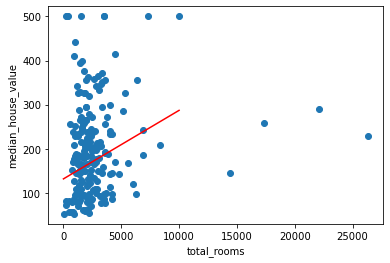

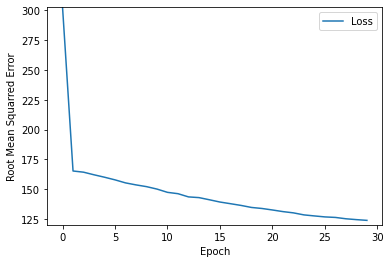

In [20]:
# the following variables are the hyperparameter
learning_rate = 0.01
epochs = 30
batch_size = 30

# specifiy the feature and the label
my_feature = "total_rooms"
my_label = "median_house_value"

# Discard any pre-existing version of the model
my_model = None

# Invoke the functions
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, my_feature, my_label, epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias)

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

Hasilnya tidak cukup baik, mungkin karena kita hanya memakai 1 feature

## Menggunakan model untuk prediksi

kamu bisa menggunakan model yang sudah di training untuk memprediksi. Dalam praktiknya, **kamu harus melakukan prediksi pada example yang tidak dipakai untuk training**. Bagaimanapun, di latihan kali ini, kamu hanya akan bekerja menggunakan sebagian dari dataset training. Pada latihan mendatang , akan menggunakan data yang belum pernah dipake untuk training.

In [21]:
def predict_house_values(n, feature, label):
    # predict house values based on a feature
    
    batch = training_df[feature][10000:10000 + n]
    predicted_values = my_model.predict_on_batch(x=batch)
    
    print("feature  label         predicted")
    print("  value  value         value")
    print("         in thousand$  in thousand$")
    print("------------------------------------")
    for i in range(n):
        print("%5.0f %6.0f %15.0f" % (training_df[feature][10000 + i], training_df[label][10000 + i], predicted_values[i][0]))

Sekarang coba prediksi menggunakan 10 example

In [22]:
predict_house_values(10, my_feature, my_label)

feature  label         predicted
  value  value         value
         in thousand$  in thousand$
------------------------------------
 1960     53             162
 3400     92             185
 3677     69             189
 2202     62             166
 2403     80             169
 5652    295             220
 3318    500             184
 2552    342             172
 1364    118             153
 3468    128             186


### Task 2: Judge the predictive power of the model

Look at the preceding table. How close is the predicted value to the label value?  In other words, does your model accurately predict house values?  

nilai prediksi masih jauh dari nilai sebenarnya

In [23]:
# Jawaban Google

# Most of the predicted values differ significantly
# from the label value, so the trained model probably 
# doesn't have much predictive power. However, the
# first 10 examples might not be representative of 
# the rest of the examples.  

## Task 3: Try a different feature

The `total_rooms` feature had only a little predictive power. Would a different feature have greater predictive power?  Try using `population` as the feature instead of `total_rooms`. 

Note: When you change features, you might also need to change the hyperparameters.

Epoch 1/20
4250/4250 [==============================] - 3s 706us/step - loss: 26638.4241 - root_mean_squared_error: 162.9711
Epoch 2/20
4250/4250 [==============================] - 3s 624us/step - loss: 17318.2260 - root_mean_squared_error: 131.5526
Epoch 3/20
4250/4250 [==============================] - 3s 628us/step - loss: 14843.7690 - root_mean_squared_error: 121.8280
Epoch 4/20
4250/4250 [==============================] - 3s 626us/step - loss: 14551.1210 - root_mean_squared_error: 120.5964
Epoch 5/20
4250/4250 [==============================] - 4s 826us/step - loss: 14424.0509 - root_mean_squared_error: 120.0750
Epoch 6/20
4250/4250 [==============================] - 3s 709us/step - loss: 14238.9364 - root_mean_squared_error: 119.2564
Epoch 7/20
4250/4250 [==============================] - 4s 827us/step - loss: 14040.3211 - root_mean_squared_error: 118.4617
Epoch 8/20
4250/4250 [==============================] - 3s 634us/step - loss: 14374.5466 - root_mean_squared_error: 119.8851


/home/nardiyansah/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


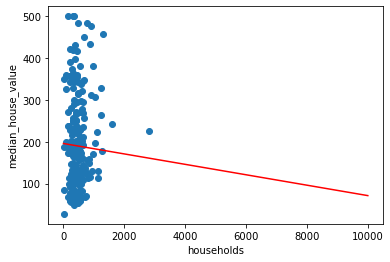

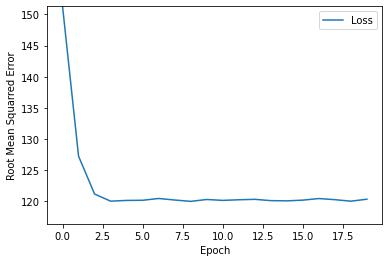

feature  label         predicted
  value  value         value
         in thousand$  in thousand$
------------------------------------
  381     53             191
  612     92             188
  785     69             186
  439     62             190
  415     80             191
 1294    295             180
  404    500             191
  424    342             191
  152    118             194
  626    128             188
  363    187             191
  164     80             194
  909    112             184
  681     95             187
  604     69             188


In [31]:
my_feature = "households"   # Replace the ? with population or possibly
                   # a different column name.

# Experiment with the hyperparameters.
learning_rate = 0.05
epochs = 20
batch_size = 4

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)
plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(15, my_feature, my_label)

Epoch 1/18
5667/5667 [==============================] - 4s 699us/step - loss: 32344.6556 - root_mean_squared_error: 179.6065 0s - loss: 32756.7357 - root_mean_squared_error: 
Epoch 2/18
5667/5667 [==============================] - 4s 685us/step - loss: 20995.0071 - root_mean_squared_error: 144.8497
Epoch 3/18
5667/5667 [==============================] - 4s 685us/step - loss: 18954.6271 - root_mean_squared_error: 137.6428
Epoch 4/18
5667/5667 [==============================] - 4s 730us/step - loss: 18183.8414 - root_mean_squared_error: 134.8418
Epoch 5/18
5667/5667 [==============================] - 4s 691us/step - loss: 18008.3396 - root_mean_squared_error: 134.1818
Epoch 6/18
5667/5667 [==============================] - 4s 693us/step - loss: 18123.8561 - root_mean_squared_error: 134.6118 0s - loss: 18123.7916 - root_mean_squared_error: 134.611
Epoch 7/18
5667/5667 [==============================] - 4s 686us/step - loss: 17813.9741 - root_mean_squared_error: 133.4532
Epoch 8/18
5667/56

/home/nardiyansah/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


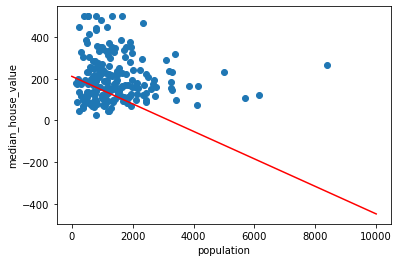

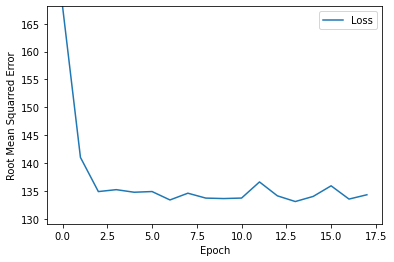

feature  label         predicted
  value  value         value
         in thousand$  in thousand$
------------------------------------
 1286     53             127
 1867     92              88
 2191     69              67
 1052     62             142
 1647     80             103
 2312    295              59
 1604    500             106
 1066    342             141
  338    118             189
 1604    128             106


In [29]:
# Jawaban Google

my_feature = "population" # Pick a feature other than "total_rooms"

# Possibly, experiment with the hyperparameters.
learning_rate = 0.05
epochs = 18
batch_size = 3

# Don't change anything below.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(10, my_feature, my_label)

Did `population` produce better predictions than `total_rooms`?

In [32]:
# Jawaban google

# Training is not entirely deterministic, but population 
# typically converges at a slightly higher RMSE than 
# total_rooms.  So, population appears to be about 
# the same or slightly worse at making predictions 
# than total_rooms.

## Task 4: Define a synthetic feature

You have determined that `total_rooms` and `population` were not useful features.  That is, neither the total number of rooms in a neighborhood nor the neighborhood's population successfully predicted the median house price of that neighborhood. Perhaps though, the *ratio* of `total_rooms` to `population` might have some predictive power. That is, perhaps block density relates to median house value.

To explore this hypothesis, do the following: 

1. Create a [synthetic feature](https://developers.google.com/machine-learning/glossary/#synthetic_feature) that's a ratio of `total_rooms` to `population`. (If you are new to pandas DataFrames, please study the [Pandas DataFrame Ultraquick Tutorial](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?utm_source=linearregressionreal-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=pandas_tf2-colab&hl=en).)
2. Tune the three hyperparameters.
3. Determine whether this synthetic feature produces 
   a lower loss value than any of the single features you 
   tried earlier in this exercise.

Epoch 1/30
850/850 [==============================] - 1s 625us/step - loss: 51536.3473 - root_mean_squared_error: 226.9056
Epoch 2/30
850/850 [==============================] - 1s 655us/step - loss: 34175.6008 - root_mean_squared_error: 184.7867
Epoch 3/30
850/850 [==============================] - 1s 645us/step - loss: 23389.3613 - root_mean_squared_error: 152.8702
Epoch 4/30
850/850 [==============================] - 1s 636us/step - loss: 17567.4841 - root_mean_squared_error: 132.5218
Epoch 5/30
850/850 [==============================] - 1s 630us/step - loss: 15535.6993 - root_mean_squared_error: 124.5763
Epoch 6/30
850/850 [==============================] - 1s 636us/step - loss: 16360.2980 - root_mean_squared_error: 127.7951
Epoch 7/30
850/850 [==============================] - 1s 639us/step - loss: 15188.9079 - root_mean_squared_error: 123.1886
Epoch 8/30
850/850 [==============================] - 1s 685us/step - loss: 14175.0852 - root_mean_squared_error: 118.9634
Epoch 9/30
850/8

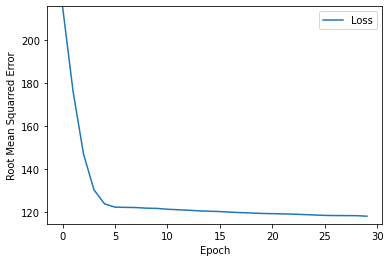

feature  label         predicted
  value  value         value
         in thousand$  in thousand$
------------------------------------
    2     53             184
    2     92             198
    2     69             191
    2     62             211
    1     80             181
    2    295             228
    2    500             210
    2    342             226
    4    118             304
    2    128             214
    2    187             227
    3     80             239
    2    112             228
    2     95             221
    2     69             210


In [36]:
# Define a synthetic feature named rooms_per_person
training_df["rooms_per_person"] = training_df["total_rooms"] / training_df["population"] # write your code here.

# Don't change the next line.
my_feature = "rooms_per_person"

# Assign values to these three hyperparameters.
learning_rate = 0.02
epochs = 30
batch_size = 20

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df,
                                         my_feature, my_label,
                                         epochs, batch_size)

plot_the_loss_curve(epochs, rmse)
predict_house_values(15, my_feature, my_label)

Epoch 1/24
567/567 [==============================] - 1s 820us/step - loss: 46157.3226 - root_mean_squared_error: 214.5985
Epoch 2/24
567/567 [==============================] - 0s 741us/step - loss: 22034.8136 - root_mean_squared_error: 148.3269
Epoch 3/24
567/567 [==============================] - 0s 704us/step - loss: 14633.5708 - root_mean_squared_error: 120.8462
Epoch 4/24
567/567 [==============================] - 0s 731us/step - loss: 15017.8029 - root_mean_squared_error: 122.3137
Epoch 5/24
567/567 [==============================] - 1s 903us/step - loss: 14294.8161 - root_mean_squared_error: 119.5058
Epoch 6/24
567/567 [==============================] - 0s 754us/step - loss: 15240.5527 - root_mean_squared_error: 123.3745
Epoch 7/24
567/567 [==============================] - 0s 856us/step - loss: 13506.5818 - root_mean_squared_error: 116.1699
Epoch 8/24
567/567 [==============================] - 0s 837us/step - loss: 13479.8349 - root_mean_squared_error: 116.0621
Epoch 9/24
567/5

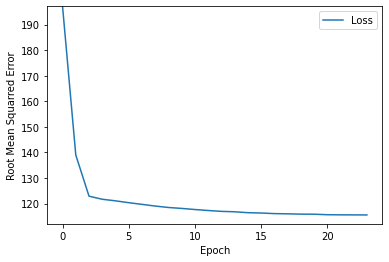

feature  label         predicted
  value  value         value
         in thousand$  in thousand$
------------------------------------
    2     53             189
    2     92             200
    2     69             195
    2     62             211
    1     80             186
    2    295             224
    2    500             210
    2    342             222
    4    118             285
    2    128             213
    2    187             223
    3     80             233
    2    112             224
    2     95             218
    2     69             210


In [37]:
# Jawaban dari Google

# Define a synthetic feature
training_df["rooms_per_person"] = training_df["total_rooms"] / training_df["population"]
my_feature = "rooms_per_person"

# Tune the hyperparameters.
learning_rate = 0.06
epochs = 24
batch_size = 30

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, mae = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

plot_the_loss_curve(epochs, mae)
predict_house_values(15, my_feature, my_label)


Based on the loss values, this synthetic feature produces a better model than the individual features you tried in Task 2 and Task 3. However, the model still isn't creating great predictions.


## Task 5. Find feature(s) whose raw values correlate with the label

So far, we've relied on trial-and-error to identify possible features for the model.  Let's rely on statistics instead.

A **correlation matrix** indicates how each attribute's raw values relate to the other attributes' raw values. Correlation values have the following meanings:

  * `1.0`: perfect positive correlation; that is, when one attribute rises, the other attribute rises.
  * `-1.0`: perfect negative correlation; that is, when one attribute rises, the other attribute falls. 
  * `0.0`: no correlation; the two column's [are not linearly related](https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Correlation_examples2.svg).

In general, the higher the absolute value of a correlation value, the greater its predictive power. For example, a correlation value of -0.8 implies far more predictive power than a correlation of -0.2.

Kode dibawah akan menghasilkan correlation matrix untuk atribut California Housing Dataset:

In [38]:
# Generate a correlation matrix
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0,-0.1
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1,0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1,-0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0,-0.1
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1,-0.0
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7,0.2
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0,0.2
rooms_per_person,-0.1,0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,0.2,1.0


The correlation matrix shows nine potential features (including a synthetic
feature) and one label (`median_house_value`).  A strong negative correlation or strong positive correlation with the label suggests a potentially good feature.  

**Your Task:** Determine which of the nine potential features appears to be the best candidate for a feature?

Epoch 1/24
567/567 [==============================] - 1s 793us/step - loss: 37263.6634 - root_mean_squared_error: 192.0716
Epoch 2/24
567/567 [==============================] - 0s 751us/step - loss: 7615.3125 - root_mean_squared_error: 87.2363
Epoch 3/24
567/567 [==============================] - 0s 869us/step - loss: 6994.9705 - root_mean_squared_error: 83.6279
Epoch 4/24
567/567 [==============================] - 1s 1ms/step - loss: 6713.6026 - root_mean_squared_error: 81.9073
Epoch 5/24
567/567 [==============================] - 0s 798us/step - loss: 6745.0902 - root_mean_squared_error: 82.0980
Epoch 6/24
567/567 [==============================] - 0s 774us/step - loss: 6937.3754 - root_mean_squared_error: 83.2755
Epoch 7/24
567/567 [==============================] - 0s 689us/step - loss: 6756.0680 - root_mean_squared_error: 82.1736
Epoch 8/24
567/567 [==============================] - 0s 725us/step - loss: 7135.8972 - root_mean_squared_error: 84.4581
Epoch 9/24
567/567 [============

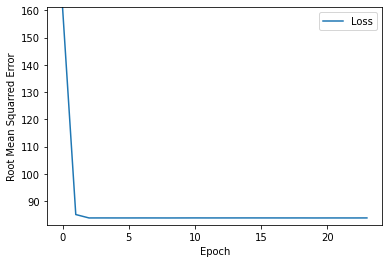

feature  label         predicted
  value  value         value
         in thousand$  in thousand$
------------------------------------
    2     53             134
    4     92             212
    3     69             154
    2     62             132
    3     80             154
    2    295             148
   10    500             457
    5    342             260
    2    118             147
    4    128             221
    8    187             397
    3     80             163
    3    112             179
    4     95             222
    2     69             143


In [39]:
# Jawaban dari Google

# Define a synthetic feature
my_feature = "median_income" # berdasarkan correlation matrix, saya pilih median_income

# Tune the hyperparameters.
learning_rate = 0.06
epochs = 24
batch_size = 30

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, mae = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

plot_the_loss_curve(epochs, mae)
predict_house_values(15, my_feature, my_label)


In [40]:
# Jawaban dari Google

# The `median_income` correlates 0.7 with the label 
# (median_house_value), so median_income` might be a 
# good feature. The other seven potential features
# all have a correlation relatively close to 0. 

# If time permits, try median_income as the feature
# and see whether the model improves.

Correlation matrices don't tell the entire story. In later exercises, you'll find additional ways to unlock predictive power from potential features.

**Note:** Using `median_income` as a feature may raise some ethical and fairness
issues. Towards the end of the course, we'll explore ethical and fairness issues.